<hr style="border:2px solid #0281c9"> </hr>

<img align="left" alt="ESO Logo" src="http://archive.eso.org/i/esologo.png">  

<div align="center">
  <h1 style="color: #0281c9; font-weight: bold;">ESO Science Archive</h1> 
  <h2 style="color: #0281c9; font-weight: bold;">Jupyter Notebooks</h2>
</div>

<hr style="border:2px solid #0281c9"> </hr>

## **Download all ALPACA FITS images for selected dawn observations (Sun at –18°)**

This notebook explores the phenomenon of **astronomical dawn** using data from the **ESO (European Southern Observatory) archive**. In particular, it makes use of the **ALPACA all-sky camera at Paranal** to study the transition between night and dawn as the Sun approaches the horizon. The analysis could, for example, focus on identifying the solar depression angle at which dawn becomes perceptible, and on comparing sky brightness and color evolution against thresholds relevant to human visual perception under mesopic and scotopic conditions.

To achieve this, the notebook retrieves **FITS image data** from the archive, processes observation times relative to the Sun’s position, and visualizes key parameters such as **sky brightness**. In addition, the script queries **ESO’s atmospheric monitoring database (`asm.dimm_paranal`)** to obtain simultaneous **seeing measurements**, enabling a direct link between sky images, metadata, and atmospheric conditions at each observation time.  

Together, these data provide a basis for investigating the fidelity of twilight observations and their connection to both physical sky conditions and the human experience of dawn.  

## **Key Steps**
1. **Define Observatory Location**  
   - Uses **Paranal Observatory, Chile** as the observation site.  
   - Computes **astronomical dawn** times (Sun at –18°) for each day.  

2. **Query ESO TAP Service**  
   - Retrieves observational data from the `ist.alpaca` table.  
   - Selects **ALPACA all-sky images** within ±30 minutes of dawn.  

3. **Cross-Match with Atmospheric Data**  
   - Queries the `asm.dimm_paranal` table.  
   - Retrieves **FWHM seeing values** at the time of each observation.  

4. **Process and Clean Data**  
   - Converts timestamps to **Modified Julian Date (MJD)**.  
   - Matches observations with solar and atmospheric conditions.  

5. **Visualize Observations**  
   - Plots **observation timestamps vs. dawn window**.  
   - Plots **FWHM seeing vs. time** across the sample.  

6. **Download & Unpack ESO FITS Files**  
   - Downloads **FITS images** from the archive.  
   - Automatically **uncompresses `.Z` files** if needed.  

## **Expected Outputs**
- List of **retrieved ALPACA observations** near dawn.  
- **Plots** of observation times relative to the Sun at –18°.  
- **Plots** of DIMM seeing (FWHM) as a function of time.  
- Downloaded **ALPACA FITS files**.  

---
**Note:** This script is designed for **ALPACA dawn analysis** but can be adapted for other ESO instruments and datasets. 🚀  

**Note:** See `ESO_Introduction` and `ESO_Query` notebooks for more basic usage.  

<hr style="border:2px solid #0281c9"> </hr>

# **Importing and basic usage of astroquery.eso**

In [1]:
import astroquery # import astroquery
print(f"astroquery version: {astroquery.__version__}") # check the version of astroquery

astroquery version: 0.4.11.dev10250


In [2]:
from astroquery.eso import Eso # import the ESO module from astroquery

In [3]:
eso = Eso() # create an instance of the ESO class 

In [4]:
eso.maxrec = 100    # For this example we limit the number of records to 3

In [5]:
# Numerical and data handling libraries
import numpy as np  # Library for numerical computations, arrays, and mathematical operations
import datetime  # Standard Python module for working with date and time objects

# Astronomical libraries
from astropy.time import Time, TimeDelta  # Handles time conversions and formats used in astronomy
from astropy.table import vstack  # Table operations for handling structured astronomical data
import astropy.units as u  # Units support for precise time window calculations

# Astronomical calculations for solar elevation and observer location
from astral import Observer  # Defines an observer’s location on Earth for solar calculations
from astral.sun import time_at_elevation  # Computes the time when the Sun reaches a specific elevation

# Visualization libraries
from matplotlib import pyplot as plt  # Core plotting library for data visualization
import matplotlib.dates as mdates  # Helper for formatting date/time data on Matplotlib plots

# File handling and system interaction
import os  # Provides functions for interacting with the operating system (e.g., file paths, directory handling)
from tqdm import tqdm  # Provides a progress bar for loops, useful for tracking long-running processes

# Stop Warnings 
import warnings  # Standard Python module for issuing warnings
warnings.filterwarnings("ignore")  # Ignore all warnings, useful for cleaner output in notebooks or scripts

## **Definitions** 

In [ ]:
# Output directories for data and figures
OUTPUT_DIR = "./data/"
OUTPUT_DIR_FIGS = "./figures/"

# Paranal Observatory Coordinates
LATITUDE = -24.6275
LONGITUDE = -70.4042
ELEVATION = 2635

# Set up Dates 
START_YEAR = 2024
START_MONTH = 1
START_DAY = 1
NUM_DAYS = 30

# Make output dirs if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_FIGS, exist_ok=True)

## **Find Data** 

In [7]:
# Define observer location
observer = Observer(LATITUDE, LONGITUDE, ELEVATION)

# Define time range for 2024
dates = [datetime.date(START_YEAR, START_MONTH, START_DAY) + datetime.timedelta(days=i) for i in range(NUM_DAYS)]

# Compute time when Sun reaches 0 degrees elevation (astronomical dawn)
sun_times = []
for date in dates:
    sun_time = time_at_elevation(observer, -18, date, direction="rising")
    sun_times.append(sun_time)

# Convert to ISO format and Modified Julian Date (MJD) for TAP queries
sun_times = [Time(t).isot for t in sun_times]
sun_times_mjd = Time(sun_times).mjd

# Tolerance window for observations around dawn (in minutes)
tolerance_minutes = 30  # ±30-minute window around astronomical dawn

# Pre-compute half-window for TAP queries
half_window = TimeDelta(tolerance_minutes * u.minute)

# Build queries for each day
query_template = """
                SELECT TOP 200 *
                FROM ist.alpaca
                WHERE instrument = 'ALPACA'
                AND date_obs BETWEEN '{start_time}' AND '{end_time}'
                ORDER BY date_obs ASC
                """

results = []

verbose = False  # Set to True for detailed output
for idx, date in enumerate(tqdm(dates, desc="Processing dates", unit="date")):
    target_time = Time(sun_times[idx])

    start_time = (target_time - half_window).isot  # Start time 30 minutes before dawn
    end_time = (target_time + half_window).isot    # End time 30 minutes after dawn
    query = query_template.format(start_time=start_time, end_time=end_time)

    if verbose:
        print(f"Querying for: {date} at LST {target_time.isot}")
    result = eso.query_tap_service(query)  # Query the TAP service with the ADQL query

    if result and len(result) > 0:

        # Convert date_obs column to Time format for comparison
        result_times = Time(list(result['date_obs'].data.data))
        
        # Identify all observations within the ±30-minute window
        time_offsets = np.abs((result_times - target_time).to_value('minute'))
        within_window = time_offsets <= tolerance_minutes

        if np.any(within_window):
            matching_results = result[within_window]
            results.append(matching_results)

            if verbose:
                closest_offset = np.min(time_offsets[within_window])
                print(f"{len(matching_results)} observation(s) within window; closest {closest_offset:.1f} minutes from dawn.")
        elif verbose:
            print("No observations within ±30 minutes of astronomical dawn.")
    elif verbose:
        print("Query returned no data for this date.")

# Stack results as astropy.table
if results:
    results = vstack(results, join_type='outer')

Processing dates: 100%|██████████| 30/30 [00:06<00:00,  4.70date/s]


## **Plot Results**

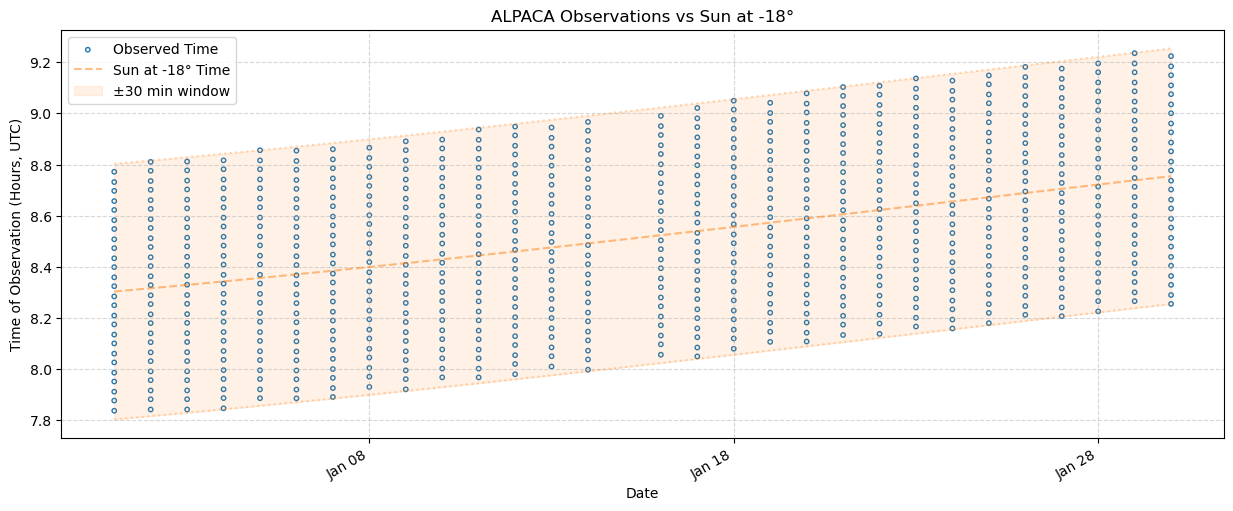

In [11]:
times_obs = [time for time in results["date_obs"]]
times_obs_mjd = Time(times_obs).mjd

fig, ax = plt.subplots(figsize=(15, 6))

# Convert times to datetime objects
dates =     [t.datetime.date() for t in Time(times_obs_mjd, format="mjd")]
obs_times = [t.datetime for t in Time(times_obs_mjd, format="mjd")]  # Full datetime
obs_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in obs_times]  # Convert to fractional hours

# Convert Sun at -35° times
sun_dates = [t.datetime.date() for t in Time(sun_times_mjd, format="mjd")]
sun_times_ = [t.datetime for t in Time(sun_times, format="isot")]
sun_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in sun_times_]

# Scatter plot for observations
ax.scatter(dates, obs_hours, label="Observed Time", ec="C0", fc="none", s=10)

# Scatter plot for Sun at -18° times
# ax.scatter(sun_dates, sun_hours, label="Sun at -35° Time", color='C1', marker='x')
ax.plot(sun_dates, sun_hours, color="C1", ls="--", alpha=0.5, label="Sun at -18° Time")
# add shaded region for ±30 minutes
ax.fill_between(sun_dates, np.array(sun_hours) - 0.5, np.array(sun_hours) + 0.5, color='C1', alpha=0.1, label="±30 min window")
ax.plot(sun_dates, np.array(sun_hours) - 0.5, color='C1', ls=':', alpha=0.3)
ax.plot(sun_dates, np.array(sun_hours) + 0.5, color='C1', ls=':', alpha=0.3)


# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Month Day"
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Show ticks every 5 days
fig.autofmt_xdate()

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Time of Observation (Hours, UTC)")
ax.set_title("ALPACA Observations vs Sun at -18°")
ax.legend()
ax.grid(ls='--', alpha=0.5)

# Save the figure
fig.savefig(f"{OUTPUT_DIR_FIGS}/alpaca_dawn_date_obs.png", dpi=300)

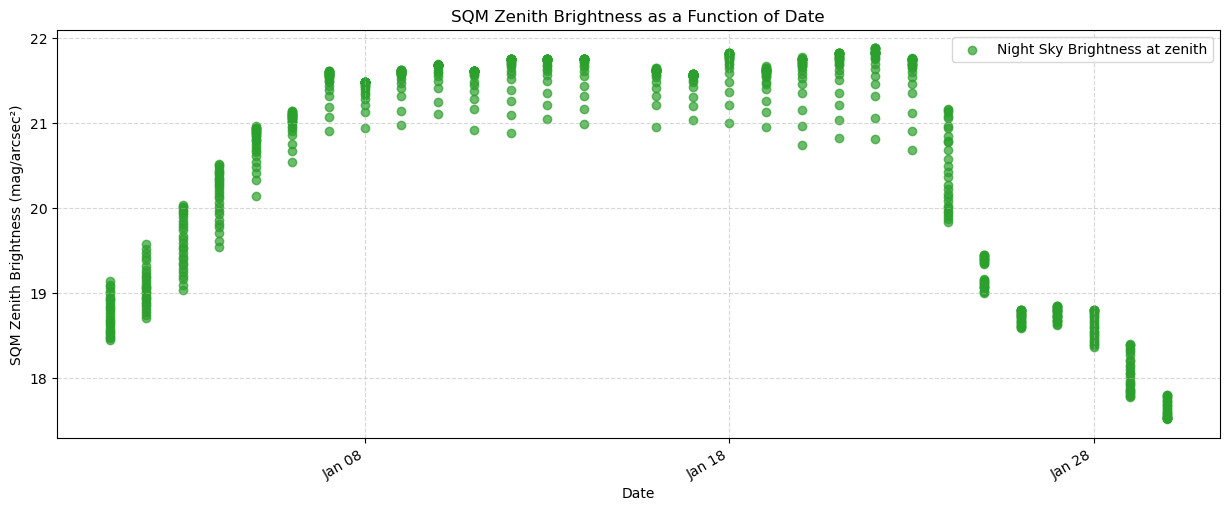

In [14]:
# Convert date_obs to MJD
times_obs = [time for time in results["date_obs"]]
times_obs_mjd = Time(times_obs).mjd

# Convert MJD to datetime
dates = [t.datetime.date() for t in Time(times_obs_mjd, format="mjd")]

# Extract SQM Zenith values
sqm_zen_values = results["sqm_zen"]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Scatter plot for SQM Zenith Brightness
ax.scatter(dates, sqm_zen_values, color="C2", label="Night Sky Brightness at zenith", alpha=0.7)

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
fig.autofmt_xdate()

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("SQM Zenith Brightness (mag/arcsec²)")
ax.set_title("SQM Zenith Brightness as a Function of Date")
ax.legend()
ax.grid(ls='--', alpha=0.5)

# Save the figure
fig.savefig(f"{OUTPUT_DIR_FIGS}/alpaca_dawn_sqm_zen.png", dpi=300)

In [12]:
times_obs = [time for time in results["date_obs"]]

# Pre-compute half-window for TAP queries
tolerance_minutes = 1
half_window = TimeDelta(tolerance_minutes * u.minute)

# Build queries for each day
query_template = """
                SELECT *
                FROM asm.dimm_paranal 
                WHERE midpoint_date BETWEEN '{start_time}' AND '{end_time}'
                """

results_atm = []

verbose = False  # Set to True for detailed output
for idx, date in enumerate(tqdm(times_obs, desc="Processing dates", unit="date")):

    target_time = Time(times_obs[idx])

    start_time = (target_time - half_window).isot  # Start time 1 minutes before obs
    end_time = (target_time + half_window).isot    # End time 1 minutes after obs
    query = query_template.format(start_time=start_time, end_time=end_time)

    if verbose:
        print(f"Querying for: {date} at LST {target_time.isot}")
    result = eso.query_tap_service(query)  # Query the TAP service with the ADQL query

    if result and len(result) > 0:

         # Convert date_obs column to Time format for comparison
        result_times = Time(list(result['midpoint_date'].data.data))
        
        # Find the closest observation
        closest_index = np.argmin(np.abs(result_times - target_time))
        closest_result = result[closest_index]
        closest_time = Time(closest_result['midpoint_date'])

        # Compute time difference (in hours)
        time_difference = np.abs((closest_time - target_time).to_value('minute'))

    # Check if observation is within tolerance
    if time_difference <= tolerance_minutes:
        results_atm.append(closest_result)
        if verbose: 
            print(f"Closest observations found: {closest_result['midpoint_date']}")
    elif time_difference > tolerance_minutes:
        if verbose: 
            print(f"Closest observation outside tolerance: {closest_result['midpoint_date']}")
    else: 
        if verbose: 
            print(f"No observations found: {closest_result['midpoint_date']}")
        continue

# Stack results as astropy.table
if results_atm:
    results_atm = vstack(results_atm, join_type='outer')

Processing dates: 100%|██████████| 777/777 [02:02<00:00,  6.33date/s]


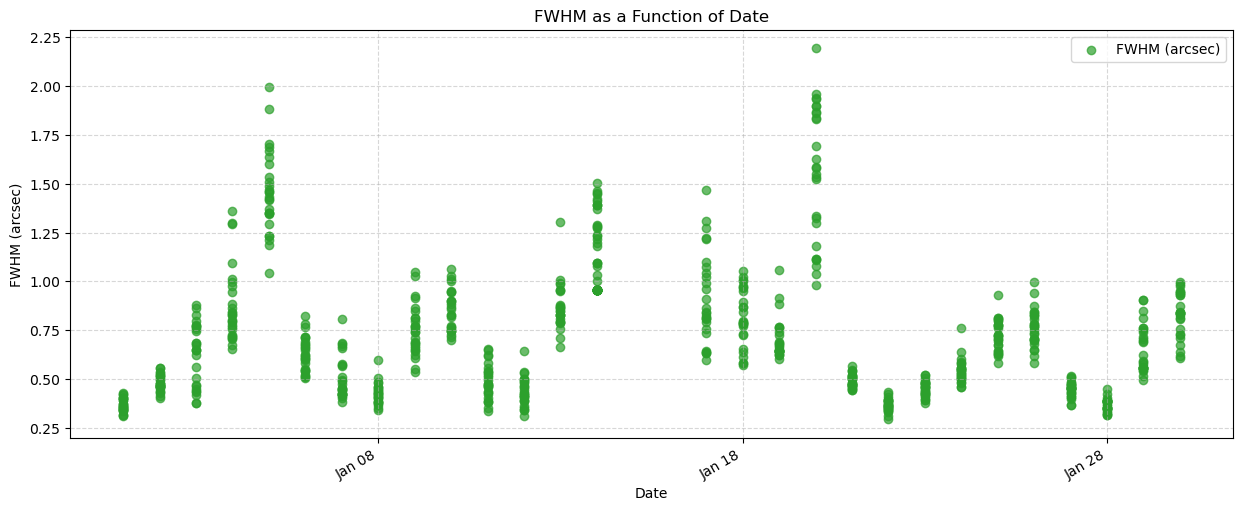

In [18]:
# Convert date_obs to MJD
times_obs = [time for time in results_atm["midpoint_date"]]
times_obs_mjd = Time(times_obs).mjd

# Convert MJD to datetime
dates = [t.datetime.date() for t in Time(times_obs_mjd, format="mjd")]

# Extract SQM Zenith values
fwhm = results_atm["fwhm"]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Scatter plot for FWHM
ax.scatter(dates, fwhm, color="C2", label="FWHM (arcsec)", alpha=0.7)

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
fig.autofmt_xdate()

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("FWHM (arcsec)")
ax.set_title("FWHM as a Function of Date")
ax.legend()
ax.grid(ls='--', alpha=0.5)

# Save the figure
fig.savefig(f"{OUTPUT_DIR_FIGS}/alpaca_dawn_fwhm.png", dpi=300)

Saved: ./figs//alpaca_dawn_multipanel_grid_4x4.png


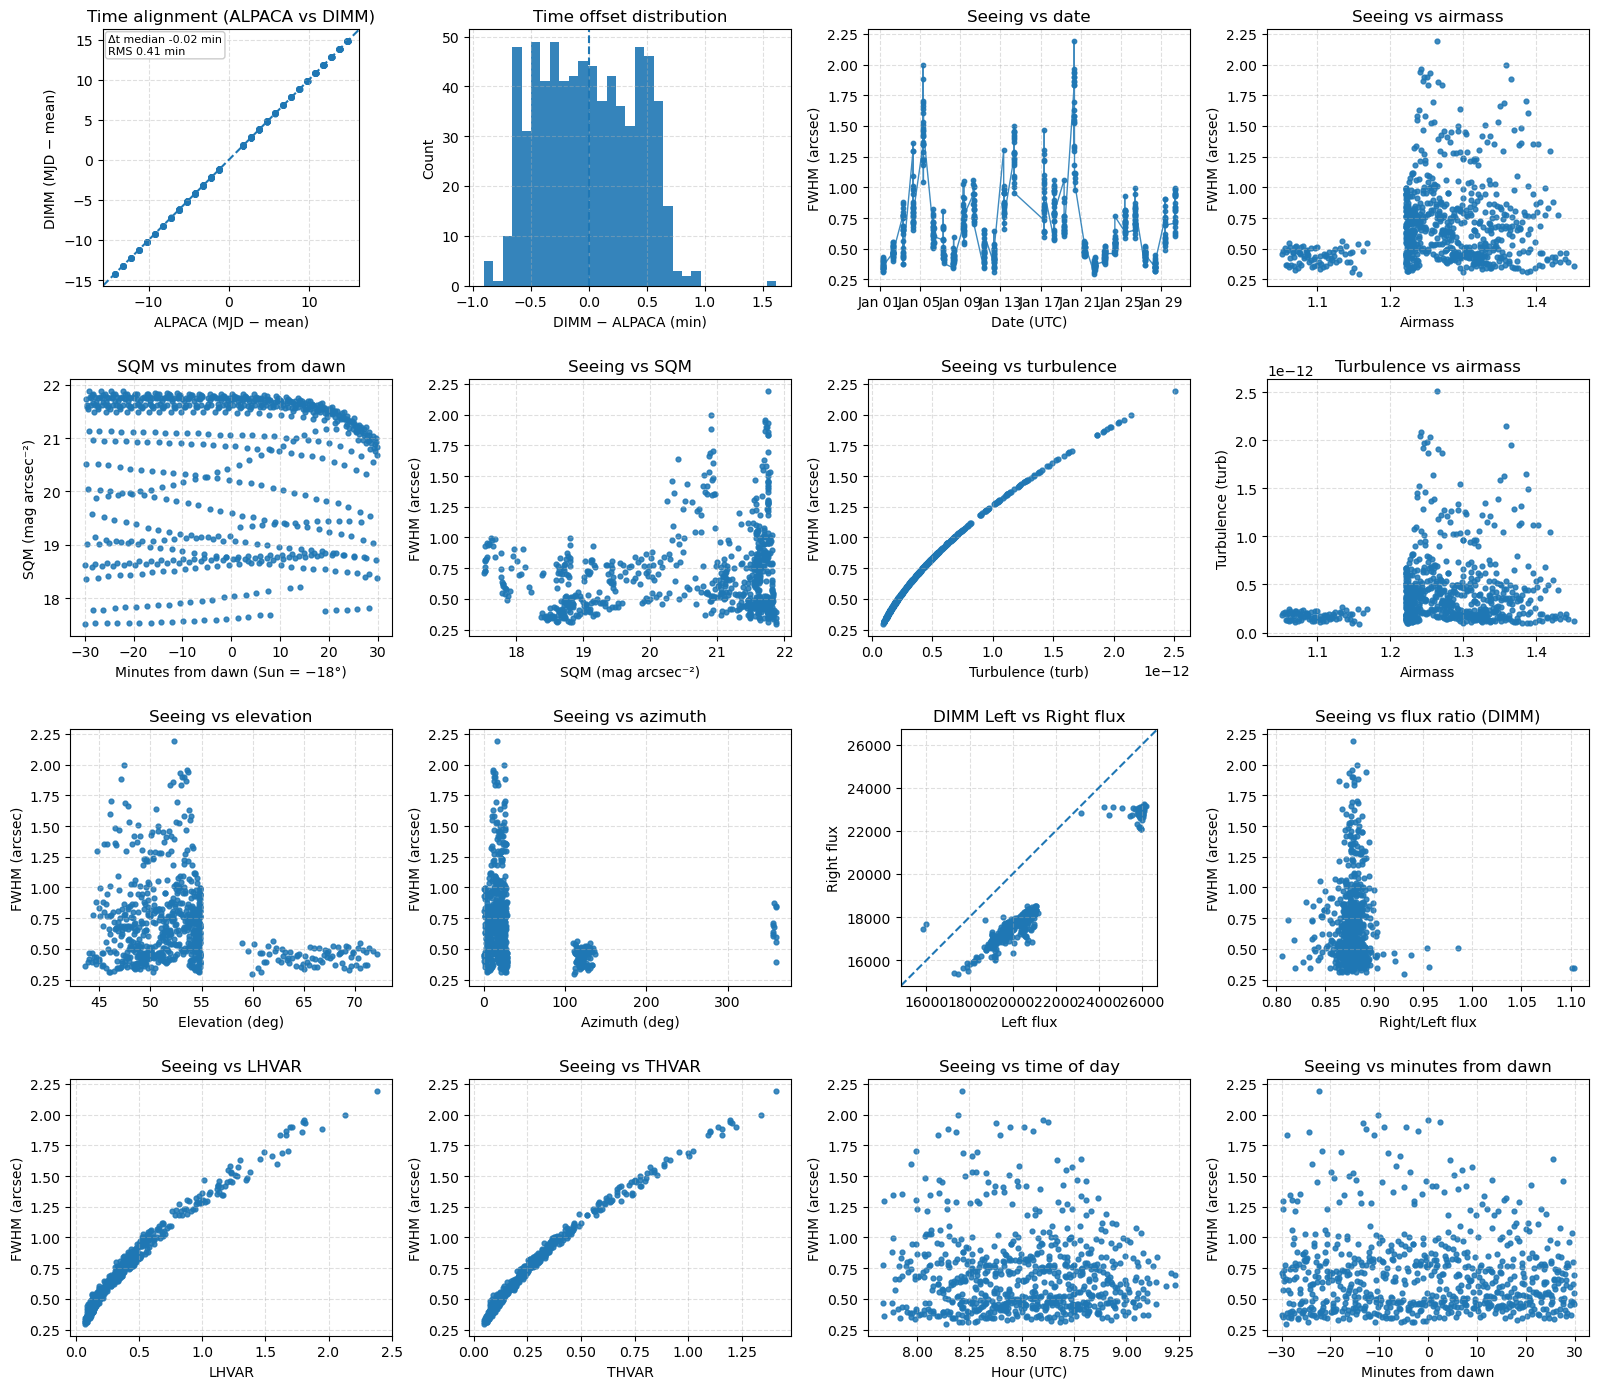

In [20]:
# === Super-grid multipanel (4x4 or 5x4) for ALPACA × DIMM dawn analysis ===
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time

# ---------- helpers ----------
def as_float(arr):
    if arr is None: return None
    try:
        return np.asarray(arr, dtype=float)
    except Exception:
        # Try masked array data
        return np.asarray(np.ma.filled(arr, np.nan), dtype=float)

def finite_mask(*arrays):
    m = None
    for a in arrays:
        a = as_float(a)
        if a is None: 
            return None
        mi = np.isfinite(a)
        m = mi if m is None else (m & mi)
    return m

def add_scatter(ax, x, y, xlabel, ylabel, title, refline=None, xspan=None, yspan=None, annotate=None):
    ax.scatter(x, y, s=12, alpha=0.85)
    if refline == "y=x":
        lo = np.nanmin(np.concatenate([x, y]))
        hi = np.nanmax(np.concatenate([x, y]))
        pad = 0.05 * (hi - lo if hi > lo else 1.0)
        lo, hi = lo - pad, hi + pad
        ax.plot([lo, hi], [lo, hi], ls="--")
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    if xspan: ax.set_xlim(*xspan)
    if yspan: ax.set_ylim(*yspan)
    ax.grid(ls="--", alpha=0.4)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    if annotate:
        ax.text(0.02, 0.98, annotate, transform=ax.transAxes, va="top", ha="left",
                bbox=dict(boxstyle="round,pad=0.25", fc="w", ec="0.8"), fontsize=8)

def add_hist(ax, data, bins=30, xlabel="", ylabel="Count", title="", vlines=None):
    ax.hist(data, bins=bins, alpha=0.9)
    if vlines is not None:
        for v in vlines:
            ax.axvline(v, ls="--")
    ax.grid(ls="--", alpha=0.4)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)

# ---------- core series ----------
obs_times = Time(list(results["date_obs"]))                      # ALPACA times
atm_times_all = Time(list(results_atm["midpoint_date"]))         # DIMM times

# Optional/interesting columns
sqm_all     = as_float(results["sqm_zen"]) if "sqm_zen" in results.colnames else None
fwhm_all    = as_float(results_atm["fwhm"]) if "fwhm" in results_atm.colnames else None
airmass_all = as_float(results_atm["airmass"]) if "airmass" in results_atm.colnames else None
alt_all     = as_float(results_atm["alt"]) if "alt" in results_atm.colnames else None
az_all      = as_float(results_atm["az"]) if "az" in results_atm.colnames else None
lflux_all   = as_float(results_atm["lflux"]) if "lflux" in results_atm.colnames else None
rflux_all   = as_float(results_atm["rflux"]) if "rflux" in results_atm.colnames else None
lhvar_all   = as_float(results_atm["lhvar"]) if "lhvar" in results_atm.colnames else None
thvar_all   = as_float(results_atm["thvar"]) if "thvar" in results_atm.colnames else None

# turbulence preference
turb_key = next((k for k in ("turb","lturb","tturb") if k in results_atm.colnames), None)
turb_all = as_float(results_atm[turb_key]) if turb_key else None

# ---------- time matching (nearest DIMM within ±2 min) ----------
tol_min = 2.0
if len(obs_times)==0 or len(atm_times_all)==0:
    raise RuntimeError("Need non-empty results and results_atm.")

dt_matrix = np.abs((obs_times[:, None] - atm_times_all[None, :]).to_value("minute"))
nearest_idx = np.argmin(dt_matrix, axis=1)
nearest_dt  = dt_matrix[np.arange(len(obs_times)), nearest_idx]
keep = nearest_dt <= tol_min
if not np.any(keep):
    raise RuntimeError(f"No ALPACA–DIMM matches within ±{tol_min} minutes.")

obs_mat = obs_times[keep]
atm_mat = atm_times_all[nearest_idx[keep]]
dt_signed_min = (atm_mat - obs_mat).to_value("minute")  # DIMM - ALPACA

# slice matched series
def match(arr):
    if arr is None: return None
    return arr[nearest_idx[keep]]

sqm     = match(sqm_all)
fwhm    = match(fwhm_all)
airmass = match(airmass_all)
alt     = match(alt_all)
az      = match(az_all)
lflux   = match(lflux_all)
rflux   = match(rflux_all)
lhvar   = match(lhvar_all)
thvar   = match(thvar_all)
turb    = match(turb_all)

# minutes from astronomical dawn (Sun = -18°)
minutes_from_dawn = None
try:
    sunT = Time(sun_times, format="isot")
    sun_lookup = {t.datetime.date(): t for t in sunT}
    obs_dates = [t.datetime.date() for t in obs_mat]
    minutes_from_dawn = np.array([(obs_mat[i] - sun_lookup.get(obs_dates[i], obs_mat[i])).to_value("minute")
                                  for i in range(len(obs_mat))], dtype=float)
except Exception:
    pass

# ---------- build panels list (x, y, labels, title, renderer) ----------
panels = []

# A) Time alignment
x_c = obs_mat.mjd - np.nanmean(obs_mat.mjd)
y_c = atm_mat.mjd - np.nanmean(atm_mat.mjd)
panels.append(("scatter", x_c, y_c, "ALPACA (MJD − mean)", "DIMM (MJD − mean)",
               "Time alignment (ALPACA vs DIMM)", {"refline":"y=x",
               "annotate":f"Δt median {np.nanmedian(dt_signed_min):+.2f} min\nRMS {np.sqrt(np.nanmean(dt_signed_min**2)):.2f} min"}))

# B) Time offset histogram
panels.append(("hist", dt_signed_min, None, "DIMM − ALPACA (min)", "Count",
               "Time offset distribution", {"vlines":[0.0]}))

# C) Seeing vs date
if fwhm is not None:
    panels.append(("series", [t.datetime for t in atm_mat], fwhm, "Date (UTC)", "FWHM (arcsec)",
                   "Seeing vs date", {"datefmt":"%b %d"}))

# D) Seeing vs airmass
if fwhm is not None and airmass is not None:
    m = finite_mask(fwhm, airmass)
    if m is not None and np.any(m):
        panels.append(("scatter", airmass[m], fwhm[m], "Airmass", "FWHM (arcsec)", "Seeing vs airmass", {}))

# E) SQM vs minutes from dawn
if (sqm is not None) and (minutes_from_dawn is not None):
    m = finite_mask(sqm, minutes_from_dawn)
    if m is not None and np.any(m):
        panels.append(("scatter", minutes_from_dawn[m], sqm[m], "Minutes from dawn (Sun = −18°)",
                       "SQM (mag arcsec⁻²)", "SQM vs minutes from dawn", {}))

# F) Seeing vs SQM
if (fwhm is not None) and (sqm is not None):
    m = finite_mask(fwhm, sqm)
    if m is not None and np.any(m):
        panels.append(("scatter", sqm[m], fwhm[m], "SQM (mag arcsec⁻²)", "FWHM (arcsec)", "Seeing vs SQM", {}))

# G) Seeing vs turbulence
if (fwhm is not None) and (turb is not None):
    m = finite_mask(fwhm, turb)
    if m is not None and np.any(m):
        tlabel = f"Turbulence ({turb_key})" if turb_key else "Turbulence"
        panels.append(("scatter", turb[m], fwhm[m], tlabel, "FWHM (arcsec)", "Seeing vs turbulence", {}))

# H) Turbulence vs airmass
if (turb is not None) and (airmass is not None):
    m = finite_mask(turb, airmass)
    if m is not None and np.any(m):
        panels.append(("scatter", airmass[m], turb[m], "Airmass", f"Turbulence ({turb_key})", "Turbulence vs airmass", {}))

# I) Altitude vs seeing
if (alt is not None) and (fwhm is not None):
    m = finite_mask(alt, fwhm)
    if m is not None and np.any(m):
        panels.append(("scatter", alt[m], fwhm[m], "Elevation (deg)", "FWHM (arcsec)", "Seeing vs elevation", {}))

# J) Azimuth vs seeing
if (az is not None) and (fwhm is not None):
    m = finite_mask(az, fwhm)
    if m is not None and np.any(m):
        panels.append(("scatter", az[m], fwhm[m], "Azimuth (deg)", "FWHM (arcsec)", "Seeing vs azimuth", {}))

# K) Left vs right flux (DIMM) — coherence proxy
if (lflux is not None) and (rflux is not None):
    m = finite_mask(lflux, rflux)
    if m is not None and np.any(m):
        panels.append(("scatter", lflux[m], rflux[m], "Left flux", "Right flux", "DIMM Left vs Right flux", {"refline":"y=x"}))

# L) Flux ratio vs seeing
if (lflux is not None) and (rflux is not None) and (fwhm is not None):
    m = finite_mask(lflux, rflux, fwhm)
    if m is not None and np.any(m):
        ratio = (rflux[m] / lflux[m])
        panels.append(("scatter", ratio, fwhm[m], "Right/Left flux", "FWHM (arcsec)", "Seeing vs flux ratio (DIMM)", {}))

# M) LHVAR vs seeing
if (lhvar is not None) and (fwhm is not None):
    m = finite_mask(lhvar, fwhm)
    if m is not None and np.any(m):
        panels.append(("scatter", lhvar[m], fwhm[m], "LHVAR", "FWHM (arcsec)", "Seeing vs LHVAR", {}))

# N) THVAR vs seeing
if (thvar is not None) and (fwhm is not None):
    m = finite_mask(thvar, fwhm)
    if m is not None and np.any(m):
        panels.append(("scatter", thvar[m], fwhm[m], "THVAR", "FWHM (arcsec)", "Seeing vs THVAR", {}))

# O) Time-of-day vs seeing (hours UTC)
hours = np.array([t.datetime.hour + t.datetime.minute/60 + t.datetime.second/3600 for t in atm_mat])
if fwhm is not None:
    m = finite_mask(hours, fwhm)
    if m is not None and np.any(m):
        panels.append(("scatter", hours[m], fwhm[m], "Hour (UTC)", "FWHM (arcsec)", "Seeing vs time of day", {}))

# P) Minutes from dawn vs seeing
if (minutes_from_dawn is not None) and (fwhm is not None):
    m = finite_mask(minutes_from_dawn, fwhm)
    if m is not None and np.any(m):
        panels.append(("scatter", minutes_from_dawn[m], fwhm[m], "Minutes from dawn", "FWHM (arcsec)",
                       "Seeing vs minutes from dawn", {}))

# Q) Airmass vs SQM
if (airmass is not None) and (sqm is not None):
    m = finite_mask(airmass, sqm)
    if m is not None and np.any(m):
        panels.append(("scatter", airmass[m], sqm[m], "Airmass", "SQM (mag arcsec⁻²)", "SQM vs airmass", {}))

# R) Altitude vs SQM
if (alt is not None) and (sqm is not None):
    m = finite_mask(alt, sqm)
    if m is not None and np.any(m):
        panels.append(("scatter", alt[m], sqm[m], "Elevation (deg)", "SQM (mag arcsec⁻²)", "SQM vs elevation", {}))

# ---------- draw grid ----------
GRID_ROWS, GRID_COLS = 4, 4   # set to (5,4) for 20 panels
N = GRID_ROWS * GRID_COLS
fig, axes = plt.subplots(GRID_ROWS, GRID_COLS, figsize=(4.0*GRID_COLS, 3.5*GRID_ROWS))
axes = np.ravel(axes)

for i in range(N):
    ax = axes[i]
    if i >= len(panels):
        ax.axis("off")
        continue
    kind, x, y, xlabel, ylabel, title, opts = panels[i]
    if kind == "scatter":
        add_scatter(ax, x, y, xlabel, ylabel, title,
                    refline=opts.get("refline"), annotate=opts.get("annotate"))
    elif kind == "hist":
        add_hist(ax, x, bins=opts.get("bins", 31), xlabel=xlabel, ylabel=ylabel, title=title,
                 vlines=opts.get("vlines"))
    elif kind == "series":
        ax.plot(x, y, lw=1.0, alpha=0.85)
        ax.scatter(x, y, s=10, alpha=0.9)
        if opts.get("datefmt"):
            ax.xaxis.set_major_formatter(mdates.DateFormatter(opts["datefmt"]))
        ax.grid(ls="--", alpha=0.4)
        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)

plt.tight_layout()
outpath = f"{OUTPUT_DIR_FIGS}/alpaca_dawn_multipanel_grid_{GRID_ROWS}x{GRID_COLS}.png"
fig.savefig(outpath, dpi=300)
print(f"Saved: {outpath}")

## **Download Data**

In [ ]:
data_files = eso.retrieve_data(results["dp_id"][0], destination=OUTPUT_DIR) # download the first data product
data_files

<hr style="border:2px solid #0281c9"> </hr>